In [3]:
import os
os.system("pip install annoy")
os.system("pip install gensim")
os.system("pip install sentence-transformers")

0

In [108]:
from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os
import glob
import psutil
from PIL import Image
import glob
import torch
import pickle
import lmdb
import random

import annoy

from sentence_transformers import SentenceTransformer, util

In [5]:
data_path = "drive/MyDrive/Temp/Flickr_1000/"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
img_model = SentenceTransformer('clip-ViT-B-32')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [8]:
def get_image_embeddings_from_path(img_model, data_path):
  img_names = list(glob.glob(f'{data_path}*.[jpg][png][jpeg]'))
  print("Images:", len(img_names))
  img_emb = img_model.encode([Image.open(filepath) for filepath in img_names], 
                             batch_size=128, convert_to_tensor=True, show_progress_bar=True)

  return {"img_names": img_names, "img_emb": img_emb, "id": range(1, len(img_names)+1)}


def get_image_embedding(img_model, image_path):

  img_emb = img_model.encode([Image.open(image_path)], 
                             batch_size=1, convert_to_tensor=True, show_progress_bar=True)
  return img_emb


#get_image_embedding(img_model, data_path+"42637986_135a9786a6.jpg")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 2.8974e-01,  1.5095e-02,  1.1794e-01, -2.2062e-01,  4.8613e-01,
         -2.8419e-02,  5.0540e-01,  1.9286e-01,  6.6897e-02,  1.4261e-01,
          1.4515e-03, -2.3007e-01, -7.1361e-02, -2.7240e-01,  1.6572e-01,
         -6.4449e-02, -8.8492e-01,  3.2516e-02,  2.5573e-01, -5.2592e-01,
         -2.6036e-01, -4.1135e-01, -8.6807e-02,  1.8807e-01,  1.6846e-01,
          4.4814e-02, -2.6312e-01, -3.6721e-02, -1.4875e-01,  2.3175e-02,
         -2.9002e-01,  6.0403e-01, -8.7001e-02, -3.4481e-01, -2.2302e-01,
          2.3179e-01, -5.4081e-01,  2.9719e-01, -1.0321e-01,  7.5424e-01,
          1.1814e-01, -4.6921e-02,  8.5481e-02, -1.0496e-02,  6.3748e-01,
         -1.0105e+00,  1.9403e-01,  2.5635e-01, -3.8667e-01,  7.4612e-03,
          9.9350e-02, -3.3152e-01,  1.4755e-01, -2.8666e-01, -2.2272e-01,
         -1.9777e-01, -1.4597e-01,  2.9829e-01, -2.4223e-01, -1.3123e-01,
         -3.3106e-01,  1.0853e-01,  2.7773e-03,  5.0458e-01, -1.4819e-01,
         -7.2754e-02,  5.4912e-02,  1.

In [9]:
image_embed_dict = get_image_embeddings_from_path(img_model, data_path)

Images: 800


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
image_embed_dict

{'img_names': ['drive/MyDrive/Temp/Flickr_1000/101654506_8eb26cfb60.jpg',
  'drive/MyDrive/Temp/Flickr_1000/101669240_b2d3e7f17b.jpg',
  'drive/MyDrive/Temp/Flickr_1000/10815824_2997e03d76.jpg',
  'drive/MyDrive/Temp/Flickr_1000/104136873_5b5d41be75.jpg',
  'drive/MyDrive/Temp/Flickr_1000/103205630_682ca7285b.jpg',
  'drive/MyDrive/Temp/Flickr_1000/107582366_d86f2d3347.jpg',
  'drive/MyDrive/Temp/Flickr_1000/103106960_e8a41d64f8.jpg',
  'drive/MyDrive/Temp/Flickr_1000/106490881_5a2dd9b7bd.jpg',
  'drive/MyDrive/Temp/Flickr_1000/106514190_bae200f463.jpg',
  'drive/MyDrive/Temp/Flickr_1000/105342180_4d4a40b47f.jpg',
  'drive/MyDrive/Temp/Flickr_1000/102455176_5f8ead62d5.jpg',
  'drive/MyDrive/Temp/Flickr_1000/107318069_e9f2ef32de.jpg',
  'drive/MyDrive/Temp/Flickr_1000/103195344_5d2dc613a3.jpg',
  'drive/MyDrive/Temp/Flickr_1000/102351840_323e3de834.jpg',
  'drive/MyDrive/Temp/Flickr_1000/108898978_7713be88fc.jpg',
  'drive/MyDrive/Temp/Flickr_1000/109823397_e35154645f.jpg',
  'drive/MyD

In [39]:
def create_index(index_path_name, image_embed_dict, num_trees=30, verbose=True):
    
    #image_embed_dict = get_image_embeddings_from_path(img_model, data_path)

    annoy_lmdb = index_path_name+".lmdb"
    annoy_index = index_path_name+".annoy"
    embed_size = image_embed_dict['img_emb'][0].shape[0]

    if verbose:
        print("Vector size: {}".format(embed_size))
    
    env = lmdb.open(annoy_lmdb, map_size=int(1e9))

    if not os.path.exists(annoy_index) or not os.path.exists(annoy_lmdb):
        i = 0
        a = annoy.AnnoyIndex(embed_size)
        with env.begin(write=True) as txn:
            for index, (i, vec, img_name) in enumerate(zip(image_embed_dict['id'], 
                                                           image_embed_dict['img_emb'], 
                                                           image_embed_dict['img_names'])):
                a.add_item(i, vec)
                id = 'ID_%d' % i
                word = 'I_' + img_name
                txn.put(id.encode(), word.encode())
                txn.put(word.encode(), id.encode())
                i += 1
                if verbose:
                    if i % 1000 == 0:
                        print(i, '...')
        if verbose:
            print("Starting to build")
        a.build(num_trees)
        if verbose:
            print("Finished building")
        a.save(annoy_index)
        if verbose:
            print("Annoy index saved to: {}".format(annoy_index))
            print("lmdb map saved to: {}".format(annoy_lmdb))
    else:
        print("Annoy index and lmdb map already in path")

In [40]:
create_index("flickr_sample", image_embed_dict)

Vector size: 512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  app.launch_new_instance()


Starting to build
Finished building
Annoy index saved to: flickr_sample.annoy
lmdb map saved to: flickr_sample.lmdb


In [41]:
!ls

drive  flickr_sample.annoy  flickr_sample.lmdb	sample_data


In [42]:
# !rm -rf flickr_sample.annoy  flickr_sample.lmdb

In [43]:
embed_size = image_embed_dict['img_emb'][0].shape[0]

a = annoy.AnnoyIndex(embed_size)
a.load("flickr_sample.annoy")
env = lmdb.open("flickr_sample.lmdb", map_size=int(1e9))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
a.get_nns_by_vector

In [101]:
def search_images_by_image(image_model, image_name, num_results, verbose=True):
    ret_keys = []
    with env.begin() as txn:
        id = int(txn.get(('I_' + image_name).encode()).decode()[3:])
        if verbose:
            print("Query: {}, with id: {}".format(image_name, id))

        v = get_image_embedding(image_model, image_name)[0]

        #v = a.get_item_vector(id)
        
        for id in a.get_nns_by_vector(v, num_results+1):
            key = txn.get((('ID_%d' % id).encode()))
            ret_keys.append(key)
    if verbose:
        print("Found: {} results".format(len(ret_keys)))
    return [key.decode().strip("I_") for key in ret_keys][1:]

In [102]:
search_images_by_image(img_model, 'drive/MyDrive/Temp/Flickr_1000/95734038_2ab5783da7.jpg', 10)

Query: drive/MyDrive/Temp/Flickr_1000/95734038_2ab5783da7.jpg, with id: 782


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found: 11 results


['drive/MyDrive/Temp/Flickr_1000/95734036_bef6d1a871.jpg',
 'drive/MyDrive/Temp/Flickr_1000/54501196_a9ac9d66f2.jpg',
 'drive/MyDrive/Temp/Flickr_1000/95728660_d47de66544.jpg',
 'drive/MyDrive/Temp/Flickr_1000/294549892_babb130543.jpg',
 'drive/MyDrive/Temp/Flickr_1000/319870744_0e0138d205.jpg',
 'drive/MyDrive/Temp/Flickr_1000/302983277_69a4e732e4.jpg',
 'drive/MyDrive/Temp/Flickr_1000/390992388_d74daee638.jpg',
 'drive/MyDrive/Temp/Flickr_1000/58363930_0544844edd.jpg',
 'drive/MyDrive/Temp/Flickr_1000/116409198_0fe0c94f3b.jpg',
 'drive/MyDrive/Temp/Flickr_1000/278388986_78ba84eb8f.jpg']

In [103]:
import numpy as np
import matplotlib.pyplot as plt
  
def plot_images(images,query_image, n_row=2, n_col=2):
    plt.imshow(query_image)
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img)
    plt.show()

In [107]:
image_embed_dict.keys()

dict_keys(['img_names', 'img_emb', 'id'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

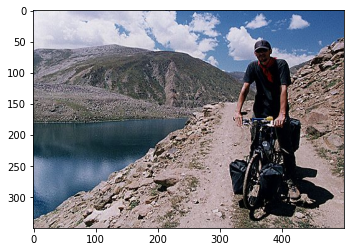

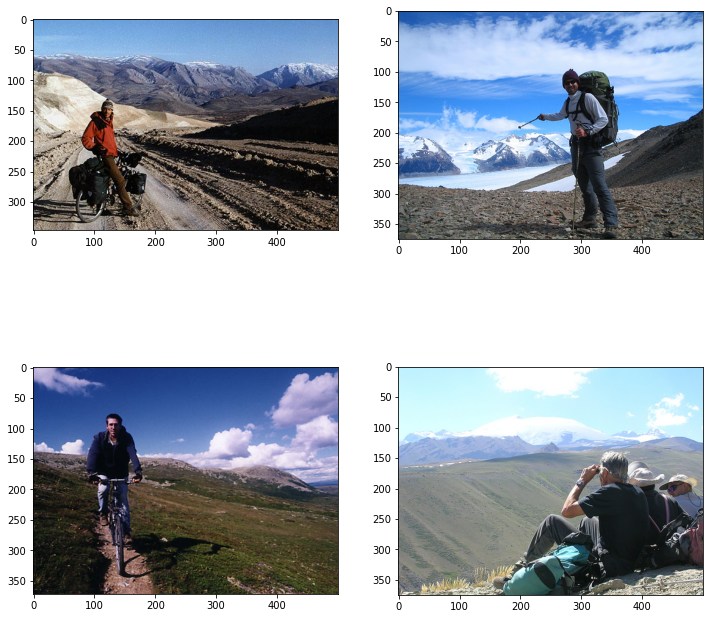

In [113]:
query_image = "drive/MyDrive/Temp/Flickr_1000/95734038_2ab5783da7.jpg"

#query_image = random.choice(image_embed_dict['img_names'])

similar_images = search_images_by_image(img_model,
                                        query_image,
                                        num_results=10,
                                        verbose=False
                                        )

plot_images([Image.open(img) for img in similar_images], Image.open(query_image))

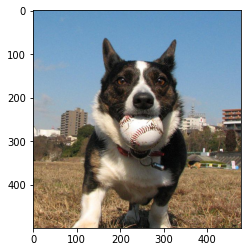

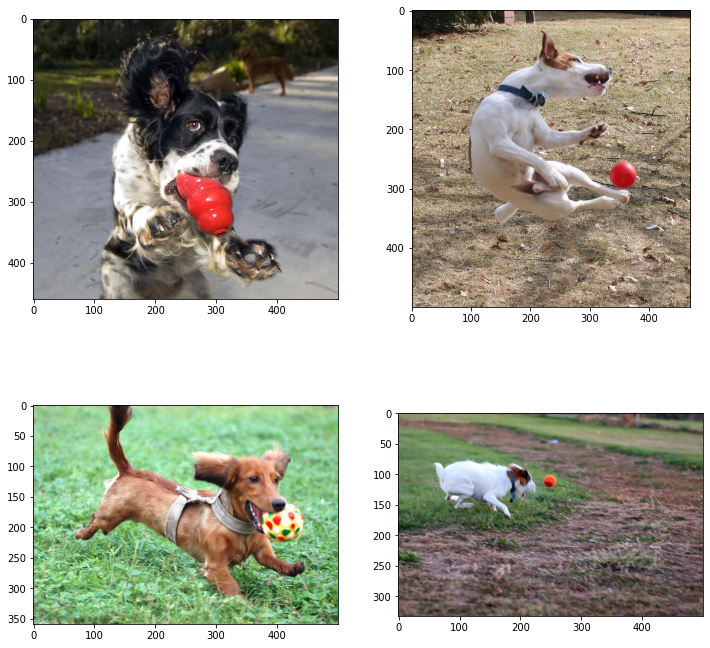